(7,1,3) Steane Code
```
Lx = [1 1 1 1 1 1 1]

     ⌈1 0 0 0 1 1 1⌉
Hx = |0 1 0 1 1 0 1|
     ⌊0 0 1 1 1 1 0⌋

     ⌈1 0 0 0 0 0 0⌉
Ex = |0 1 0 0 0 0 0|
     ⌊0 0 1 0 0 0 0⌋
```
Below is a decoder to correct bitflips as according to Hx.

In [47]:
import numpy as np

# Lx = np.array([1,1,1,1,1,1,1])
Hx = np.array([[1,0,0,0,1,1,1],[0,1,0,1,1,0,1],[0,0,1,1,1,1,0]])
# Ex = np.array([[1,0,0,0,0,0,0],[0,1,0,0,0,0,0],[0,0,1,0,0,0,0]])

bitwise_add = lambda a, b: (a + b) % 2
num_bits = 7

def to_bits(n:int):
    bits:list[int] = []
    while n > 0:
        bits.append(n%2)
        n //= 2
    while len(bits) < num_bits:
        bits.append(0)
    bits.reverse()
    return np.array([bits])

def from_bits(bits:list[int]) -> int:
    num = 0
    bits = list(bits)
    bits.reverse()
    while len(bits) > 0:
        num *= 2
        num += bits.pop()
    return num

def determine_fix(recvd_msg:np.ndarray): 
    syndrome: np.ndarray = np.matmul(Hx,recvd_msg.transpose()) % 2
    match syndrome[0][0] * 1 + syndrome[1][0] * 2 + syndrome[2][0] * 4:
        case 0: return np.array([[0,0,0,0,0,0,0]])
        case 1: return np.array([[1,0,0,0,0,0,0]])
        case 2: return np.array([[0,1,0,0,0,0,0]])
        case 3: return np.array([[0,0,0,0,0,0,1]])
        case 4: return np.array([[0,0,1,0,0,0,0]])
        case 5: return np.array([[0,0,0,0,0,1,0]])
        case 6: return np.array([[0,0,0,1,0,0,0]])
        case 7: return np.array([[0,0,0,0,1,0,0]])
        case other:
            print(f"Error: Failed to determine fix for {syndrome}")
            return np.array([[8,8,8,8,8,8,8]])

def decode_msg(recvd_msg:np.ndarray):
    return bitwise_add(recvd_msg, determine_fix(recvd_msg))

Below is the application of decode_msg() on all 2^7 possible bitflip errors that
may occur on the 7 physical bits. If the sum of the fix + error (the output of
the decoder) is odd, then the error, ε, is determined to be uncorrectable. i.e.,

f(ε) == 1 iff Σ(ε + fix) % 2 == 1

In [48]:
def cannot_correct_error(error:np.ndarray):
    return 1 if decode_msg(error).sum() % 2 == 1 else 0

f_of_epsilon:list = []

for n in range(128):
    error = to_bits(n)
    is_error_uncorrectable = cannot_correct_error(error)
    # print(f"{error} -> ", end="")
    # print("Correctable" if is_error_uncorrectable == 0 else "Uncorrectable")
    f_of_epsilon.append([error, is_error_uncorrectable])

Below is the calculation of f(w) where:

f(wᵢ) = Average(f(ε)) for all ε of Hamming Weight wᵢ.

[0.  0.  1.  0.2 0.8 0.  1.  1. ]


<BarContainer object of 8 artists>

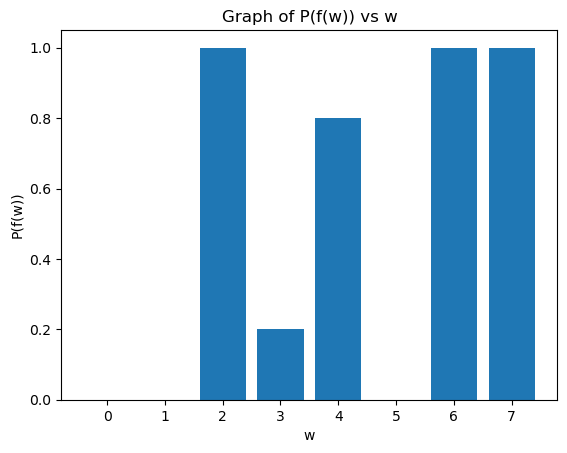

In [49]:
import matplotlib.pyplot as plt

f_of_weight_sum    = np.array([0,0,0,0,0,0,0,0]) # 0-based lists
f_of_weight_counts = np.array([0,0,0,0,0,0,0,0])
weights            = np.array([0,1,2,3,4,5,6,7])

for [error, is_error_uncorrectable] in f_of_epsilon:
    weight = error.sum()
    f_of_weight_counts[weight] += 1
    if is_error_uncorrectable:
        f_of_weight_sum[weight] += 1

f_of_weight = f_of_weight_sum / f_of_weight_counts
print(f_of_weight)

fig1, ax1 = plt.subplots()
ax1.set_title("Graph of P(f(w)) vs w")
ax1.set_xlabel("w")
ax1.set_ylabel("P(f(w))")

ax1.bar([0,1,2,3,4,5,6,7], f_of_weight)

Graph of the probability of a physical error occuring (P_phys) against the
probability of a logical error occuring (P_log).

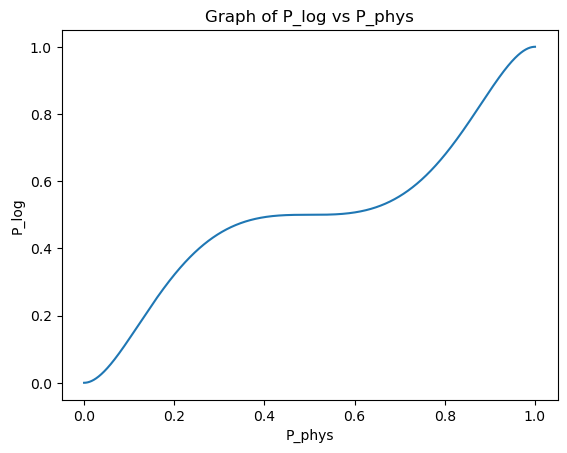

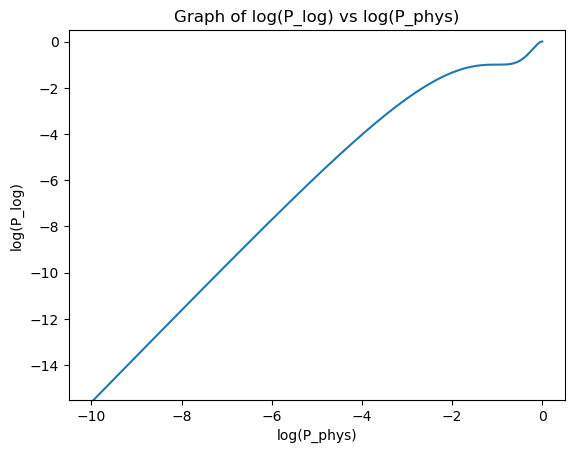

In [50]:
import scipy.stats as stats

binom_res = int(1e5)
almost_zero = 1e-20

def p_failure_calc(p_phys):
    result:float = 0
    for weight in weights:
        result += stats.binom.pmf(weight, num_bits, p_phys) * \
            f_of_weight[int(weight)]
    return result

fig2_lin, ax2_lin = plt.subplots()
ax2_lin.set_title("Graph of P_log vs P_phys")
ax2_lin.set_xlabel("P_phys")
ax2_lin.set_ylabel("P_log")

p_phys = np.linspace(0, 1, binom_res)
p_log = p_failure_calc(p_phys)
ax2_lin.plot(p_phys, p_log)
lin_theory = [p_phys, p_log]

fig2_log, ax2_log = plt.subplots()
ax2_log.set_title("Graph of log(P_log) vs log(P_phys)")
ax2_log.set_xlabel("log(P_phys)")
ax2_log.set_ylabel("log(P_log)")
ax2_log.set_xlim(-10.5,0.5)
ax2_log.set_ylim(-15.5,0.5)

p_phys = np.geomspace(almost_zero, 1, binom_res)
p_log = p_failure_calc(p_phys)
ax2_log.plot(np.log2(p_phys), np.log2(p_log))
log_theory = [np.log2(p_phys), np.log2(p_log)]

Monte Carlo for estimating the graphs above.

In [51]:
rng = np.random.default_rng()
num_samples = 5000
sim_res = 500
confidence = 0.95

p_phys_list = np.geomspace(almost_zero, 1, sim_res)

means  = []
stds   = []
errors = []
confs  = []

for p_phys in p_phys_list:
    random_nums = rng.random(size=(1, num_samples, num_bits))
    resolve_error = lambda e: 1 if e <= p_phys else 0

    epsilons = np.apply_along_axis(resolve_error, 0, random_nums)
    epsilons = np.apply_along_axis(lambda x: [x], 1, epsilons)
    results = []
    for epsilon in epsilons:
        results.append(cannot_correct_error(epsilon))

    error = np.std(results)/np.sqrt(num_samples)
    errors.append(error)
    means.append(np.mean(results))
    stds.append(np.std(results))
    confs.append(abs(stats.norm.ppf((1-confidence)/2))*error)

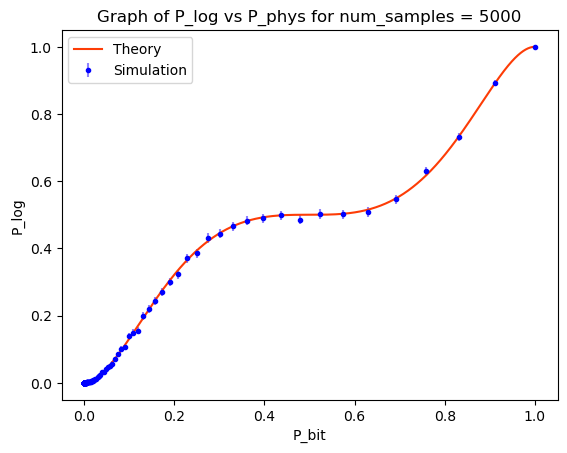

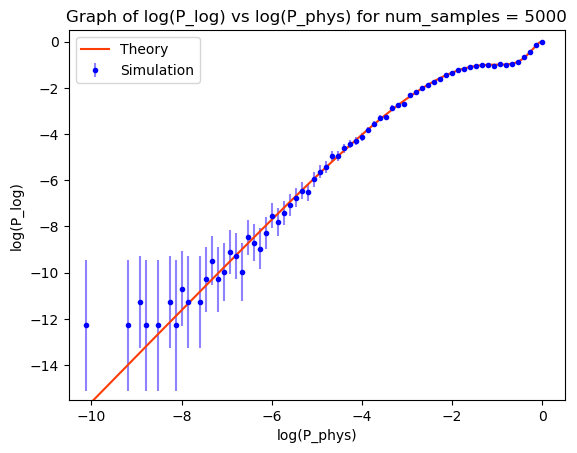

In [52]:
fig3_lin, ax3_lin = plt.subplots()
ax3_lin.set_title(f"Graph of P_log vs P_phys for num_samples = {num_samples}")
ax3_lin.set_xlabel("P_bit")
ax3_lin.set_ylabel("P_log")

ax3_lin.errorbar(p_phys_list, means, confs, label="Simulation", fmt="b.",
                ecolor="xkcd:periwinkle")
ax3_lin.plot(lin_theory[0], lin_theory[1], "xkcd:red orange",
                label="Theory")
handles, labels = ax3_lin.get_legend_handles_labels()
ax3_lin.legend(handles, labels)

fig3_log, ax3_log = plt.subplots()
ax3_log.set_title(f"Graph of log(P_log) vs log(P_phys) for num_samples = {num_samples}")
ax3_log.set_xlabel("log(P_phys)")
ax3_log.set_ylabel("log(P_log)")
ax3_log.set_xlim(-10.5,0.5)
ax3_log.set_ylim(-15.5,0.5)

means_sans_zero = list(map(lambda x: x if x > 0 else almost_zero, means))
stds_sans_zero = list(map(lambda x: x if x > 0 else almost_zero, stds))

p_phys_list_log = np.log2(p_phys_list)
means_log = np.log2(means_sans_zero)
stds_log = abs(stds_sans_zero/np.array(list(map(lambda m: m*np.log(2), means_sans_zero))))
errors_log = stds_log/np.sqrt(num_samples)
confs_log = abs(stats.norm.ppf((1-confidence)/2))*errors_log


ax3_log.errorbar(p_phys_list_log, means_log, confs_log, label="Simulation",
                fmt="b.", ecolor="xkcd:periwinkle")
ax3_log.plot(log_theory[0], log_theory[1], "xkcd:red orange",
                label="Theory")
handles, labels = ax3_log.get_legend_handles_labels()
ax3_log.legend(handles, labels)

Estimation of f(w) using indivisual samples of f(ε) for each wᵢ ∈ w. As shown
below, for w = 3 and w = 4, the percision of the estimation of f(w) may become
arbiterily good depending on the number of samples taken.

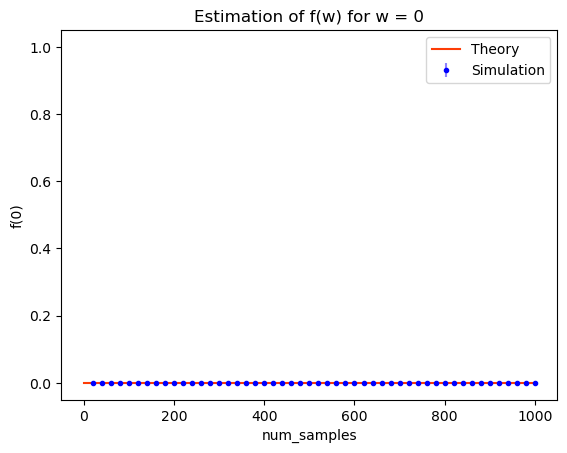

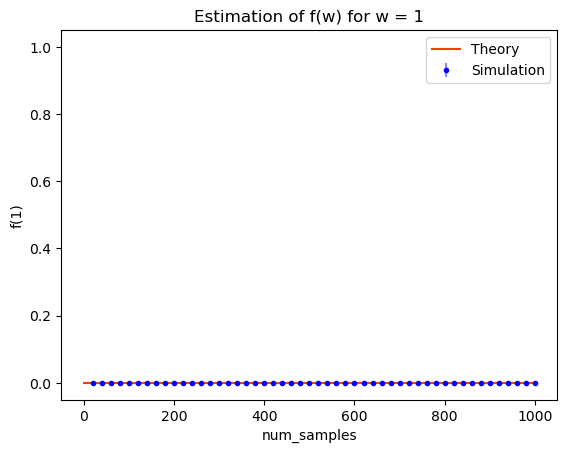

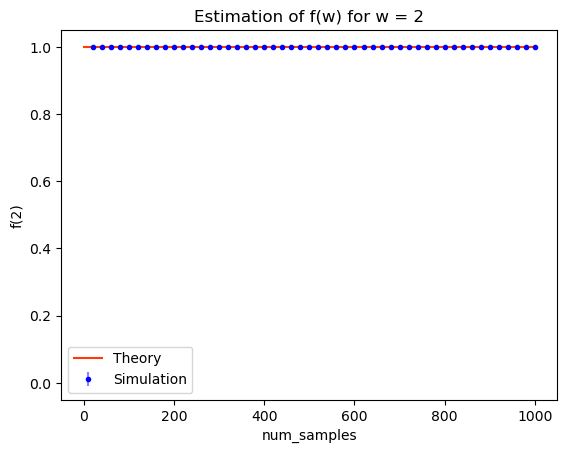

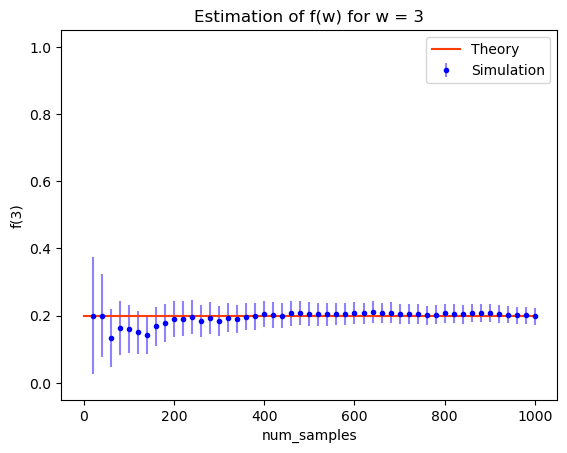

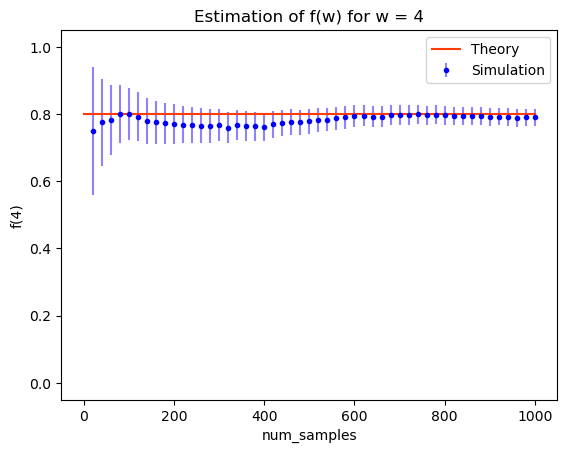

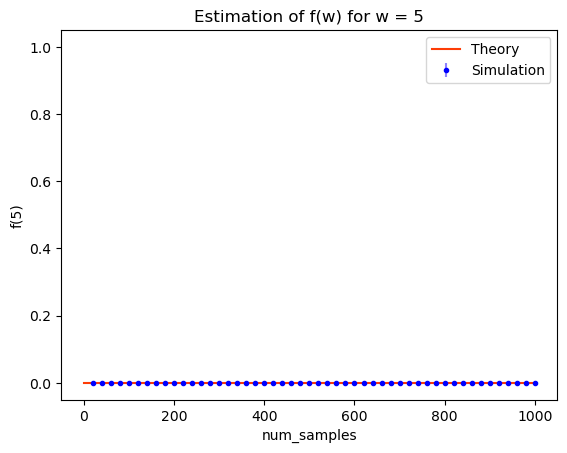

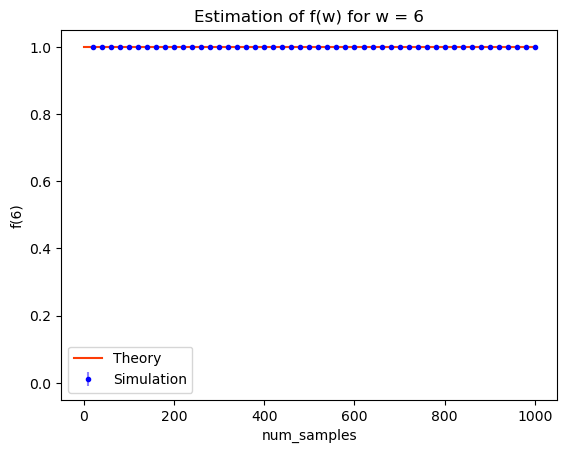

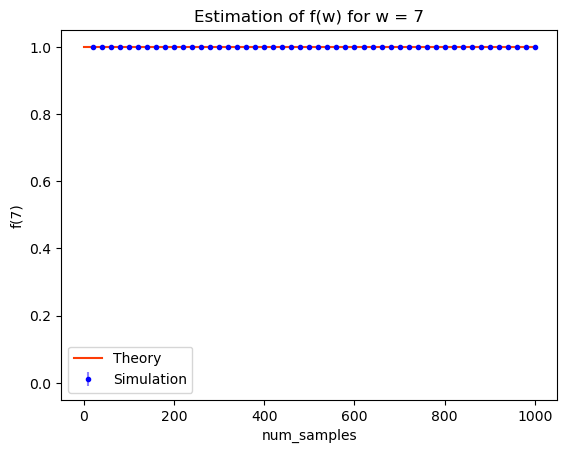

In [55]:
num_samples = 1000
step = 20

for w in weights:
    epsilon_base = np.array([0,0,0,0,0,0,0])
    for idx in range(w):
        epsilon_base[idx] = 1

    results = []
    epsilons = []
    for _ in range(num_samples):
        epsilon = np.array(epsilon_base)
        rng.shuffle(epsilon)
        results.append(cannot_correct_error(np.array([epsilon])))

    means  = []
    confs  = []

    for increment in range(int(np.ceil(num_samples/step))):
        span  = (increment + 1) * step

        mean  = np.mean(results[0:span])
        std   = np.std(results[0:span])
        error = np.std(results[0:span])/np.sqrt(span)
        conf  = abs(stats.norm.ppf((1-confidence)/2))*error
        
        means.append(mean)
        confs.append(conf)

    fig4, ax4 = plt.subplots()
    ax4.set_title(f"Estimation of f(w) for w = {w}")
    ax4.set_xlabel("num_samples")
    ax4.set_ylabel(f"f({w})")
    ax4.set_ylim(-0.05, 1.05)
    ax4.errorbar(np.arange(0,num_samples,step)+step,means,confs, label="Simulation",
                    fmt="b.", ecolor="xkcd:periwinkle")
    ax4.plot([0,num_samples], [f_of_weight[w], f_of_weight[w]], "xkcd:red orange",
                    label="Theory")
    handles, labels = ax4.get_legend_handles_labels()
    ax4.legend(handles, labels)


As shown below, for arbitrarily small values of P_phys, the probability of an
ε of w ≥ 3 can become arbitrarily small. So, given a negligibly small
probability of an ε of w ≥ 3, a related small value of P_phys may be determined.
Hence, for that P_phys or smaller, f(w) for w = 2 is sufficient.

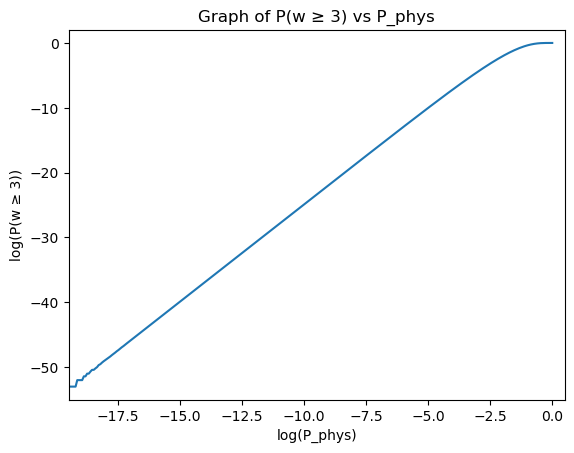

In [54]:
plot_res = 1000
p_phys = np.geomspace(almost_zero, 1, plot_res)

p_w_ge_3 = 1 - stats.binom.cdf(2, 7, p_phys)
stds_sans_zero = list(map(lambda x: x if x > 0 else almost_zero, p_w_ge_3))

fig5, ax5 = plt.subplots()
ax5.set_title(f"Graph of P(w ≥ 3) vs P_phys")
ax5.set_xlabel("log(P_phys)")
ax5.set_ylabel("log(P(w ≥ 3))")
ax5.set_xlim(-19.5, 0.5)
ax5.set_ylim(-55, 2)

ax5.plot(np.log2(p_phys), np.log2(stds_sans_zero))